https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html#sphx-glr-download-tutorial-10-key-features-005-visualization-py

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path
import optuna
from reprpo.hp.helpers import optuna_df
from reprpo.training import train
from reprpo.experiments import experiment_configs
from reprpo.hp.space import search_spaces
from optuna.study.study import storages, get_all_study_names
from reprpo.hp.helpers import get_params, get_optuna_df


[2024-10-06 11:13:49,621] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.dpi'] = 80
rcParams['figure.figsize'] = 4,2

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [9]:
from reprpo.hp.target import override, default_tuner_kwargs
from reprpo.experiments import experiment_configs
import copy

## Objective

In [5]:
SEED=42
key_metric = "acc_gain_vs_ref/oos"

In [8]:
f_db = f"sqlite:///optuna.db"
f = f_db.replace('sqlite:///', './')
print(f)
Path(f).parent.mkdir(parents=True, exist_ok=True)
f_db

./optuna.db


'sqlite:///optuna.db'

## Opt

Note on pruning. It's only really usefull with validation metrics and for long jobs over many epochs. I've got a small proxy job so there is no need.

In [10]:
def plot_param_importances(study, key_metric):
    df_res = get_optuna_df(study, key_metric)
    df2 = study.trials_dataframe().query('state == "COMPLETE"').sort_values('value', ascending=False)

    # plot_param_importances(study)
    # plt.show()

    for i in range(len(df_res)):
        row = df_res.iloc[i]
        param = row.name
        best = row.best
        x = f"params_{param}"
        hue = df2[x].apply(lambda x: x == best)
        if row.dist=='categorical':
            p = sns.catplot(data=df2, x=x, y="value", kind="boxen", 
                        #height=3, 
                        height=2, aspect=3,
                        legend=False,
                        hue=hue)
        else:
            plt.figure(figsize=(6, 2))
            sns.scatterplot(data=df2, x=x, y='value', hue=hue, alpha=0.5, ax=plt.gca())
            sns.scatterplot(data=df2[hue], x=x, y='value', ax=plt.gca(), marker='x', color='red', s=100)
            # TODO if it's a log dist make log
        plt.legend('off').remove()
        plt.title(f"{param} i={row.importance:2.2g} best={best}")
        plt.xlabel(None)
        # plt.ylabel(key_metric)
        plt.show()

projgrad2


[W 2024-10-06 11:15:37,728] Study instance does not contain completed trials.


,importance,best
"projgrad2 N=✓0/309, best=nan",,


[W 2024-10-06 11:15:37,852] Study instance does not contain completed trials.


-
side-ether-prefvec


,importance,best
"side-ether-prefvec N=✓208/209, best=1.169",,
use_angle_loss,0.196,True
β,0.181,0.403787
Htype,0.130,oft
use_dpo_loss,0.113,False
lr,0.102,0.000615
weight_tokens,0.098,False
nb,0.062,30
reduction,0.034,25
collect_input,0.025,False


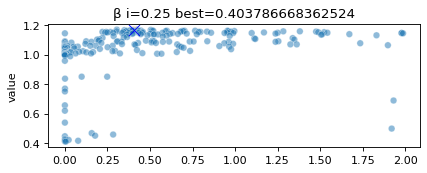

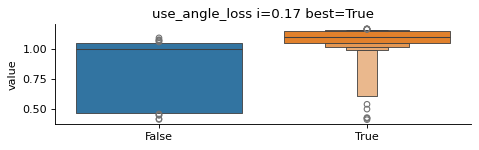

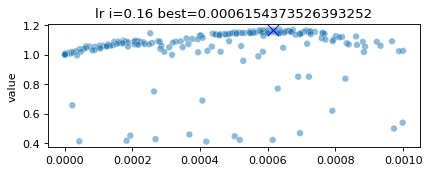

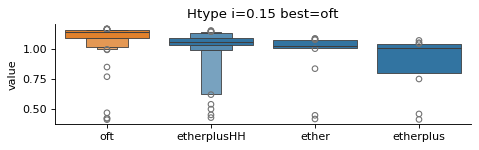

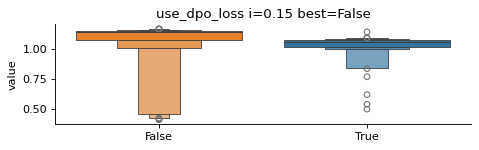

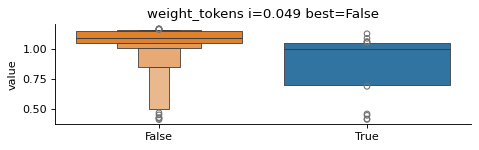

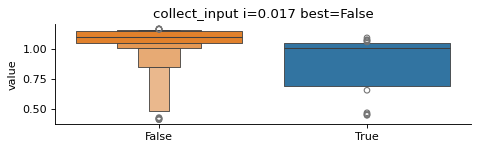

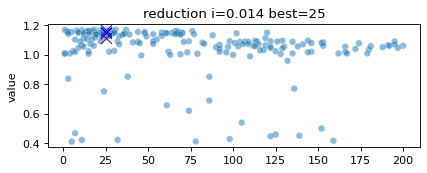

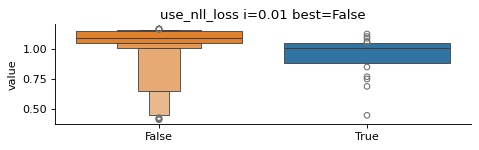

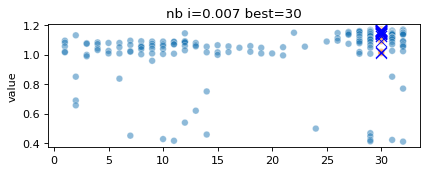

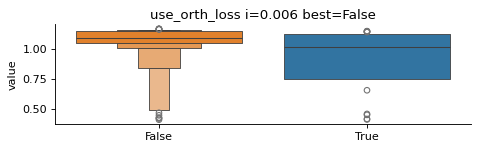

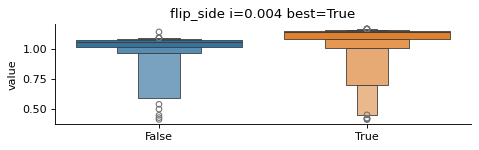

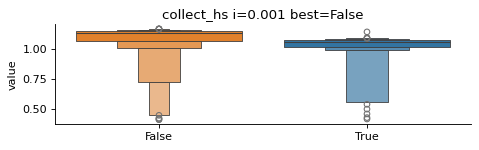

[W 2024-10-06 11:15:43,848] Study instance does not contain completed trials.


projgrad


,importance,best
"projgrad N=✓0/4, best=nan",,


[W 2024-10-06 11:15:43,923] Study instance does not contain completed trials.


-
side-svd-mse


,importance,best
"side-svd-mse N=✓28/316, best=1.010",,
lr,0.965,0.001195
α,0.017,0.635584
quantile,0.016,float
collect_hs,0.001,True
dual_svd,0.000,True
collect_input,0.000,False
quantile_value,NaN,0.3


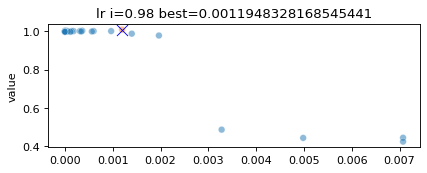

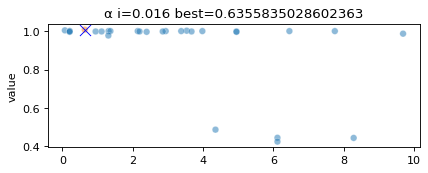

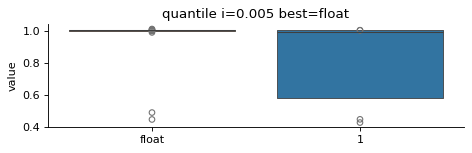

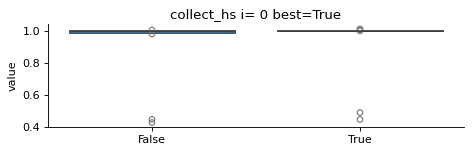

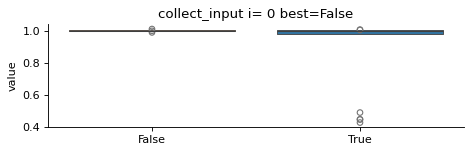

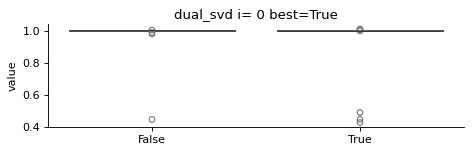

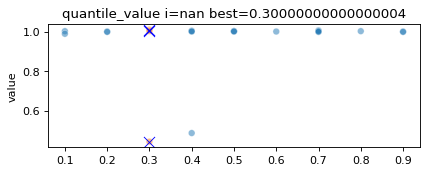

side-hra-rank


,importance,best
"side-hra-rank N=✓182/183, best=1.229",,
lr,0.933,0.000188
collect_input,0.047,False
collect_hs,0.012,False
r,0.003,2
β,0.002,0.110393
apply_GS,0.002,False
α,0.000,5.920778


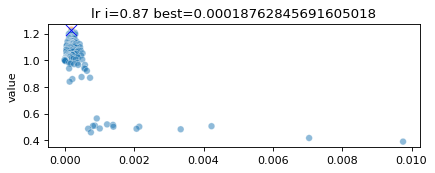

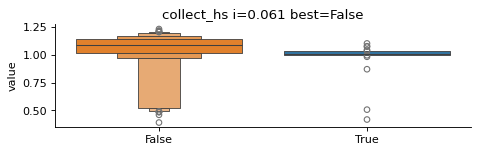

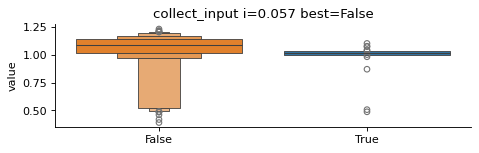

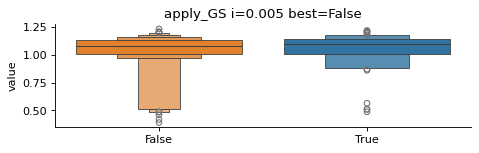

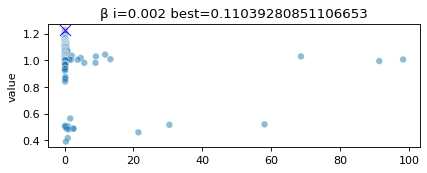

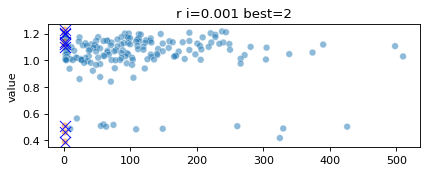

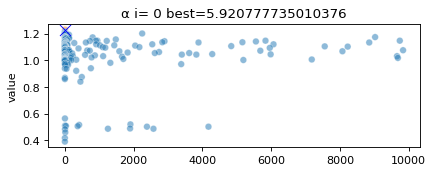

hs-ortho-prefvec


,importance,best
"hs-ortho-prefvec N=✓60/60, best=1.131",,
lr,0.962,0.000239
use_angle_loss,0.012,False
orthogonal_map,0.008,matrix_exp
β,0.006,0.218987
weight_tokens,0.005,True
use_nll_loss,0.005,False
use_dpo_loss,0.001,True
use_orth_loss,0.001,False
use_proj_rel,0.000,False


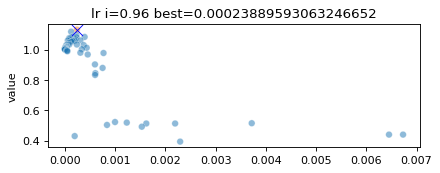

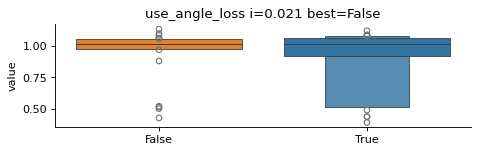

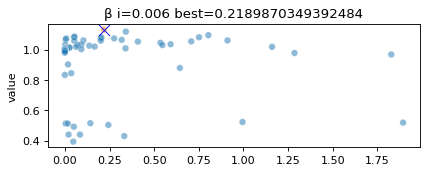

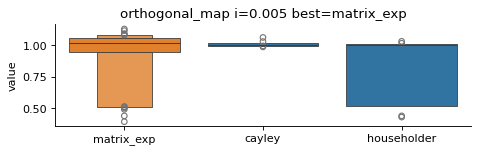

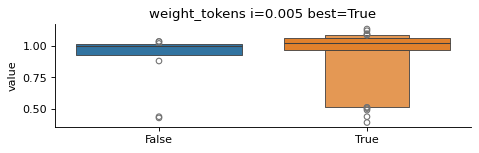

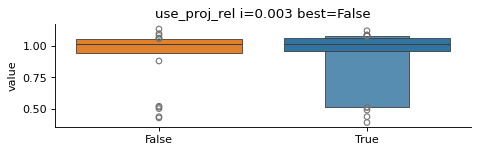

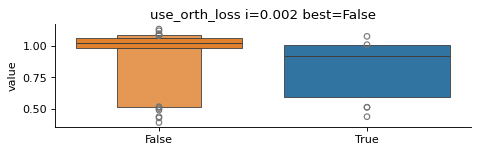

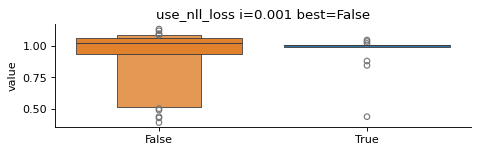

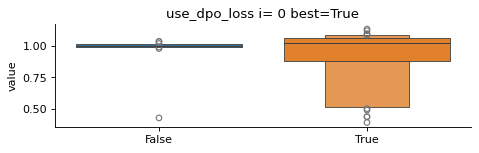

projbp


,importance,best
"projbp N=✓10/64, best=1.033",,
lr,0.806,0.000003
β,0.112,0.366362
scale_orth,0.070,False
neg_slope,0.006,0
reverse_pref,0.006,False
mag_clip,0.000,None


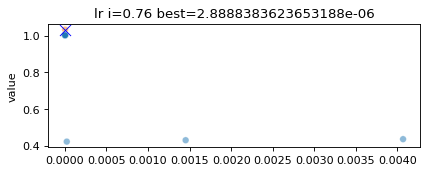

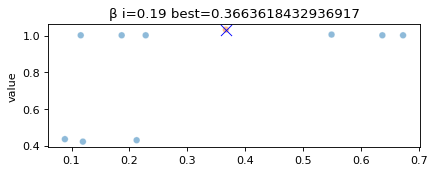

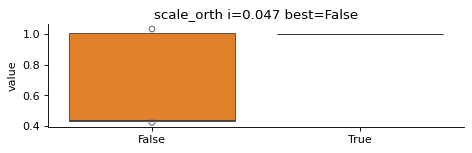

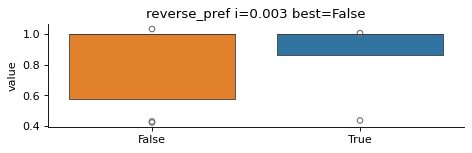

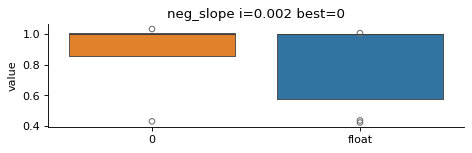

AttributeError: 'NoneType' object has no attribute 'autoscale_view'

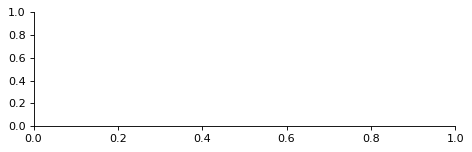

In [12]:

study_names = get_all_study_names(storage=f_db)

for study_name in study_names:
    print(study_name)
    study = optuna.load_study(study_name=study_name, storage=f_db)
    try:
        df_res2 = optuna_df(study, key_metric)
        display(df_res2)
        plot_param_importances(study, key_metric)
        # print()
    except ValueError as e:
        print('-')
    print('='*80)

In [ ]:
df_res = get_optuna_df(study, key_metric)
df_res